Title
=====

*Author:* Dr. J. Andrew Casey-Clyde

*Date:* 2024-11-14

Supermassive black holes (SMBHs) can pair as a result of galaxy mergers, eventually forming a SMBH binary (SMBHB) that emits gravitational waves before coalescing. This process is not fast, however, and is governed by different processes at different SMBH separation scales. In this notebook we model the residence timescales of SMBH pairs from the time they initially pair at large separations to the time they form a SMBHB, and finally until the SMBHB coalesces.

In [1]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
%matplotlib inline
sns.set_context("notebook")
sns.set_style('ticks')
sns.set_palette('colorblind')
rcparams = {
    'text.latex.preamble': r'\\usepackage{amsmath}',
    'text.usetex': False,
    'xtick.direction': 'in',
    'xtick.top': True,
    'xtick.minor.visible': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'ytick.minor.visible': True,
    'legend.frameon': False
    # 'axes.labelsize': 18
}
plt.rcParams.update(rcparams)
cs = plt.rcParams['axes.prop_cycle'].by_key()['color']
ls = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]

FW, FH = plt.rcParams["figure.figsize"]

# Introduction

In hierarchical galaxy assembly models, all massive galaxies are expected to have gone through at least one major merger, forming a SMBH binary (SMBHB) as a byproduct (e.g., [Volonteri, Haardt, & Madau 2003](https://ui.adsabs.harvard.edu/abs/2003RMxAC..17..333V/abstract); [Burke-Spolaor et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26ARv..27....5B/abstract); [Mingarelli 2019](https://ui.adsabs.harvard.edu/abs/2019NatAs...3....8M)).
The orbits of the SMBHs which will eventually comprise the binary initially evolve under dynamical friction, as numerous interactions between the SMBHs and the field of stars in the remnant galaxy slow the SMBHs and drive them towards the center of the remnant galaxy ([Binney & Tremaine 2008](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B); [Merritt 2013](https://ui.adsabs.harvard.edu/abs/2013degn.book.....M)).
As the SMBHs approach a separation of $\mathcal{O}(100 \; \mathrm{pc})$, their evolution becomes dominated by three-body interactions with individual stars, also known as "stellar hardening".
This process helps to harden the SMBH pair into a gravitationally bound SMBHB by ejecting stars in the vicinity of the SMBHB ([Merritt 2013](https://ui.adsabs.harvard.edu/abs/2013degn.book.....M); [Sesana & Khan 2015](http://adsabs.harvard.edu/abs/2015MNRAS.454L..66S)).
At separations of $\sim 1 \; \mathrm{pc}$ stellar hardening becomes inefficient as the SMBHB clears its vicinity of nearby stars.
At this stage interactions between the SMBHB and nearby gas may become important for further shrinking the binary orbit, though the details of this process remains an open question (see, e.g., [Farriset al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...783..134F); [Izquierdo-Villalba et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.3488I); [Siwek, Weinberger, & Hernquist 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.522.2707S)).
Finally, at separations $\lesssim 0.01 \; \mathrm{pc}$ ([Koss et al. 2023](https://ui.adsabs.harvard.edu/abs/2023ApJ...942L..24K)) a SMBHB's evolution is driven primarily by GW emission, which leeches energy from the SMBHB orbital energy.

In the following sections we model the formation and evolution of a SMBHB.
At various stages, this evolution depends on the masses of the constituent SMBHs; we therefore start by defining the grid of SMBH masses we wish to explore in the Data section.
In the Analysis section we show the evolution rate of SMBH pairs under the dynamical friction, stellar hardening, and gravitational wave regimes.
In the Modeling section we self-consistently compute the evolution rate and residence timescales of different SMBH pairs.
Finally we summarize our results in the Discussion.

# Data

The evolution rate of a pair of SMBHs at all scales can be calculated from the SMBH masses, $M_{\mathrm{BH}, 1}$ and $M_{\mathrm{BH}, 2}$, and their separation, $a$. In this section we therefore set up grids of $M_{\mathrm{BH}, 12} = M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}$, $q_{\mathrm{BH}} = M_{\mathrm{BH}, 2} / M_{\mathrm{BH}, 1} \leq 1$, and $a$ on which to compute SMBH pair evolution rates.

In [3]:
import numpy as np

# Base values to consider for total BH mass, BH mass ratio, and separations
log10_mbh12 = np.array([8, 9, 10, 11])  # log10 total BH mass [log10 Msun]
mbh12 = np.power(10, log10_mbh12)  # total BH mass [Msun]
mratq = np.array([.25, .5, .9, 1])  # unitless
a_sep = np.geomspace(1e-4, 3e4)  # parsecs

# Grids of mass and mass ratio for computations
mm, qq = np.meshgrid(mbh12, mratq, indexing='ij')

# Individual BH masses, derived from total mass and mass ratios
mbh1 = mm / (1 + qq)  # primary BH mass [Msun]
mbh2 = mbh1 * qq  # secondary BH mass [Msun]

# Analysis

## Dynamical Friction

As two galaxies merge, the initial evolution of their central SMBHs is driven by dynamical friction, i.e., by interactions between the SMBHs and passing field stars.
These progenitor SMBHs will eventually gravitationally bind to form a SMBHB.
Here we show how the separation of the progenitor SMBHs initially evolves under dynamical friction.
We closely follow the derivations in [Binney & Tremaine 2008](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B) and [Merritt 2013](https://ui.adsabs.harvard.edu/abs/2013degn.book.....M).

To simplify the dynamical friction calculation we assume that the larger, primary SMBH of mass $M_{\mathrm{BH}, 1}$ is near the center of the post-merger remnant galaxy.
We thus consider only the orbit of the lighter, secondary SMBH of mass $M_{\mathrm{BH}, 2} < M_{\mathrm{BH}, 1}$ through the remnant.
As we will see, the dynamical friction timescale, $t_{\mathrm{DF}}$, scales as $M_{\mathrm{BH}}^{-1}$, so that by the time the secondary SMBH reaches the galactic center the primary SMBH will already be in place.
Thus our assumption that we only need to consider the motion of the secondary SMBH is reasonable.

Consider a SMBH of mass $M_{\mathrm{BH}, 2}$ traveling through a field of stars of mass $m_{f} \ll M$ as a result of some recent galaxy merger.
The total mass of the remnant galaxy is $M_{*} \gg M_{\mathrm{BH}, 2}$.
As the SMBH travels through and interacts with nearby field stars it slows down at a rate ([Binney & Tremaine 2008](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B))

$$
\begin{equation}
    \frac{d \vec{v}_{\mathrm{BH}}}{dt} = -4 \pi M_{\mathrm{BH}, 2} m_{f} \ln \Lambda \int d^{3}\vec{v}_{f} \psi(\vec{v}_{f}) \frac{\vec{v}_{\mathrm{BH}} - \vec{v}_{f}}{\vert \vec{v}_{\mathrm{BH}} - \vec{v}_{f} \vert^{3}} \, ,
\end{equation}
$$

where $\ln \Lambda$ is the Coulomb logarithm, $\vec{v}_{\mathrm{BH}}$ is the velocity of the SMBH, $\vec{v}_{f}$ are the velocities of the field stars, and $\psi(\vec{v}_{f}) = \int d^{3}x \psi(\vec{x}, \vec{v}_{f})$ is the velocity distribution function of field stars, computed from the phase-space distribution function of field stars,  $\psi(\vec{x}, \vec{v}_{f})$.
$\psi(\vec{x}, \vec{v}_{f})$ is normalized to the local number density of field stars, $\phi_{f}$, such that $\int d^{3}\vec{v}_{f} \psi(\vec{x}, \vec{v}_{f}) = \phi_{f}(\vec{x})$.
We can estimate $\Lambda$ as
$$
\begin{equation}
    \Lambda \approx \frac{b_{\max} v_{\mathrm{typ}}^{2}}{M_{\mathrm{BH}, 2}} \, ,
\end{equation}
$$
where $b_{\max}$ is the impact parameter -- i.e. the distance at which a star would pass the SMBH if it felt no attraction -- and $v_{\mathrm{typ}}$ is the typical relative velocity of nearby stars.
For a SMBH of mass $M_{\mathrm{BH}, 2}$ orbiting at radius $a$ in a galaxy of mass $M_{*} \gg M_{\mathrm{BH}, 2}$ and radius $R_{*}$, the impact parameter is $b_{\max} \approx a$, and $v_{\mathrm{typ}}^{2} \approx M_{*} / R_{*}$.
The Coulomb logarithm then becomes
$$
\begin{equation}
    \ln \Lambda \approx \ln \left(\frac{a M_{*}}{R_{*} M_{\mathrm{BH}, 2}}\right) \, .
\end{equation}
$$

2024-11-18 14:43:48.955 | INFO     | oddagn.config:<module>:11 - PROJ_ROOT path is: /vast/palmer/home.grace/jc4368/oddAGN


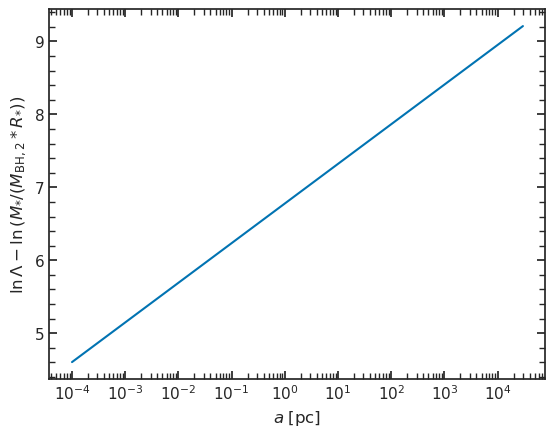

In [4]:
from oddagn.utilities import coulomb_logarithm

a_dyn_fric_plot = np.geomspace(1e2, 1e4)

# plot the Coulomb logarithm
fig, ax = plt.subplots()

mbh = 1
mstellar = 1
galaxy_radius = 1
coulog = coulomb_logarithm(a_dyn_fric_plot, mbh, mstellar, galaxy_radius)

ax.plot(a_sep, coulog - np.log(mstellar / (mbh * galaxy_radius)))

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")

ax.set_ylabel(r"$\ln \Lambda - \ln\left( M_{*} / (M_{\mathrm{BH}, 2} * R_{*}) \right)$")

plt.show()

To proceed, we must make some assumptions about the galaxy our SMBH is orbiting in.
The flatness of many galaxy rotation curves suggests the galaxy stellar mass density distribution, $\rho_{*}(a)$, can be approximated as a singular isothermal sphere
$$
\begin{equation}
    \rho_{*}(a) = \frac{v_{c}^{2}}{4 \pi a^{2}} \, ,
\end{equation}
$$
where $v_{c} = \sigma \sqrt{2}$ is the constant circular speed of orbiting stars.
The velocity distribution function for an isothermal sphere is Maxwellian,
$$
\begin{equation}
    \psi(\vec{v}_{f}) \propto \frac{1}{\left(2 \pi \sigma^{2}\right)^{3/2}} e^{-v_{f}^{2} / \left(2 \sigma^{2}\right)} \, ,
\end{equation}
$$
where $\sigma$ is the stellar velocity dispersion.
The acceleration felt by the SMBH is therefore
$$
\begin{equation}
    \dot{\vec{v}}_{\mathrm{BH}}(a) = -\frac{4 \pi M_{\mathrm{BH}, 2} \rho_{*}(a) \ln \Lambda}{v_{\mathrm{BH}}^{3}} \left[ \mathrm{erf}\left(\frac{v_{\mathrm{BH}}}{\sigma \sqrt{2}}\right) - \frac{2 v_{\mathrm{BH}}}{\sigma \sqrt{2 \pi}} \exp{- \left(\frac{v_{\mathrm{BH}}}{\sigma \sqrt{2}}\right)^{2}} \right] \vec{v}_{\mathrm{BH}} \, ,
\end{equation}
$$
where $\mathrm{erf}(x)$ is the error function.
We assume the SMBH is on a nearly circular orbit as it slowly inspirals, so that its circular speed is $v_{\mathrm{BH}} = v_{c} = \sigma \sqrt{2}$.
Substituting this in the dynamical friction equation, we find all of the terms involving $\sigma$ evaluate to constants such that the terms in the brackets evaluate to $0.428$.
Combined with $\rho_{*}(a)$, we find that the SMBH slows at a rate
$$
\begin{equation}
    \dot{\vec{v}}_{BH}(a) \approx -0.428 \ln \Lambda \frac{M_{\mathrm{BH}, 2}}{a^{2}} \frac{\vec{v}_{\mathrm{BH}}}{v_{\mathrm{BH}}} \, .
\end{equation}
$$

We can now find the rate of decay of the SMBH orbit, $da/dt$.
The angular momentum of the SMBH at each radius, $a$, is 
$$
\begin{equation}
    L = M a v_{c} \, .
\end{equation}
$$
The magnitude of the force acting on the SMBH at each $a$ is 
$$
\begin{equation}
    F(a) = M_{\mathrm{BH}, 2} \vert \dot{\vec{v}}_{BH}(a) \vert = 0.428 \ln \Lambda \frac{M_{\mathrm{BH}, 2}^{2}}{a^{2}}
\end{equation}
$$
and is tangential to the SMBH orbit and opposite its velocity.
The SMBH therefore loses angular momentum, $L$ at a rate
$$
\begin{equation}
    \frac{dL}{dt} = -F a = -0.428 \ln \Lambda \frac{M_{\mathrm{BH}, 2}^{2}}{a} \, .
\end{equation}
$$
Taking the time derivative of $L$ and setting it equal to the above equation, we find the SMBH's orbit decays at a rate
$$
\begin{equation}
    \frac{da}{dt} = -0.428 \ln \Lambda \frac{M_{\mathrm{BH}, 2}}{a v_{c}} = -0.302 \ln \Lambda \frac{M_{\mathrm{BH}, 2}}{a \sigma} \, .
\end{equation}
$$
Finally, we can calculate the dynamical friction timescale by integrating this:
$$
\begin{equation}
    t_{\mathrm{DF}} = \frac{1.65}{\ln \Lambda} \frac{a_{0}^{2} \sigma}{M_{\mathrm{BH}, 2}} \, ,
\end{equation}
$$
where $a_{0}$ is the initial orbital radius of the SMBH at time $t = 0$.

### The Coulomb Logarithm

We would like to compute the Coulomb logarithm self-consistently. Specifically, we want to account for the empirical fact that $M_{\mathrm{BH, 12}}$ is correlated with galaxy stellar mass, $M_{*}$, which in turn also determines the effective radius of the galaxy, $R_{*}$. We will deal with this latter fact first, modeling the effective galaxy radius as ([Dabringhausen, Hilker, & Kroupa 2008](http://adsabs.harvard.edu/abs/2008MNRAS.386..864D))
$$
R_{*} = \max\left\{2.95 \left(\frac{M_{*}}{10^{6} \; \mathrm{M}_{\odot}}\right)^{0.596}, 34.8 \left(\frac{M_{*}}{10^{6} \; \mathrm{M}_{\odot}}\right)^{0.399}\right\} \; \mathrm{pc} \, .
$$

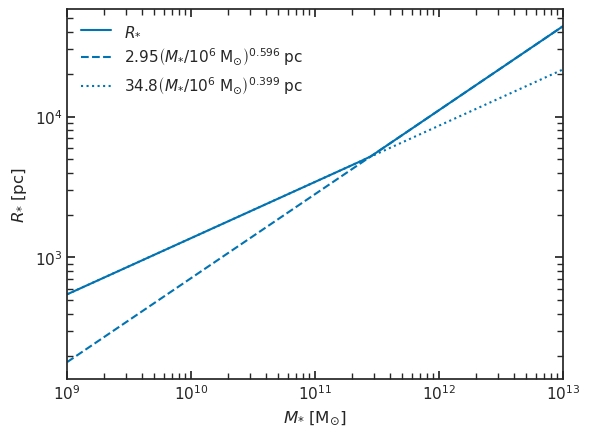

In [5]:
from oddagn.galaxy_properties import effective_radius

# plot the Mbh-Mbulge scaling from Kormendy & Ho (2013)
fig, ax = plt.subplots()

mstellar_plot = np.geomspace(1e9, 1e13)
r_eff_plot = effective_radius(mstellar_plot)

ax.plot(mstellar_plot, r_eff_plot, color=cs[0], label=r"$R_{*}$")
ax.plot(mstellar_plot, 2.95 * np.power(mstellar_plot/1e6, .596), color=cs[0], linestyle='--', 
        label=r"$2.95 \left(M_{*} / 10^{6} \; \mathrm{M}_{\odot}\right)^{0.596} \; \mathrm{pc}$")
ax.plot(mstellar_plot, 34.8 * np.power(mstellar_plot/1e6, .399), color=cs[0], linestyle=':', 
        label=r"$34.8 \left(M_{*} / 10^{6} \; \mathrm{M}_{\odot}\right)^{0.399} \; \mathrm{pc}$")

ax.set_xlabel(r"$M_{*} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_xlim(mstellar_plot.min(), mstellar_plot.max())

ax.set_ylabel(r"$R_{*} \; [\mathrm{pc}]$")
ax.set_yscale("log")
# ax.set_ylim(1e6, 2.75e10)

plt.legend()
plt.show()

We can estimate $M_{*}$ from $M_{\mathrm{BH, 12}}$ by assuming an empirical scaling between $M_{\mathrm{BH, 12}}$ and bulge mass, $M_{\mathrm{bulge}}$, (e.g., Kormendy & Ho 2013), and between $M_{\mathrm{bulge}}$ and $M_{*}$. These scalings both include intrinsic dispersion, as there is not a strict mapping between masses at any scale, which are instead probabilistically correlated, such that we have relations $P(M_{\mathrm{bulge}} \vert M_{\mathrm{BH}})$ and $P(M_{*} \vert M_{\mathrm{bulge}})$. Thus, by marginalizing over galaxy stellar mass the Coulomb logarithm becomes
$$
\begin{equation}
    \ln \Lambda \approx \iint \ln \left(\frac{a M_{*}}{R_{*}(M_{*}) M_{\mathrm{BH}, 2}}\right) P(M_{*} \vert M_{\mathrm{bulge}}) P(M_{\mathrm{bulge}} \vert M_{\mathrm{BH}}) dM_{*} dM_{\mathrm{bulge}} \, .
\end{equation}
$$

We first address the $M_{\mathrm{BH}} - M_{\mathrm{bulge}}$ scaling, which is generally given as a log-linear relation of the form
$$
\log_{10} M_{\mathrm{BH}} = \alpha_{\mathrm{BH}} \log_{10} \left(M_{\mathrm{bulge}} / 10^{11} \; \mathrm{M}_{\odot}\right) + \beta_{\mathrm{BH}} \pm \Delta_{\mathrm{BH}} \, ,
$$
where the parameter $\alpha_{\mathrm{BH}}$ determines the slope of the $M_{\mathrm{BH}} - M_{\mathrm{bulge}}$ scaling and $\beta_{\mathrm{BH}}$ is the base-10 logarithm of the overall scaling, i.e., the expected mass of a SMBH in a $10^{11} \; \mathrm{M}_{\odot}$ galactic bulge, and $\Delta_{\mathrm{BH}}$ is the intrinsic dispersion. For example, in Kormendy & Ho (2013), the authors estimate $\alpha_{\mathrm{BH}} = 1.17$, $\beta_{\mathrm{BH}} = 8.69$, and $\Delta_{\mathrm{BH}} = 0.29$, which we plot below:

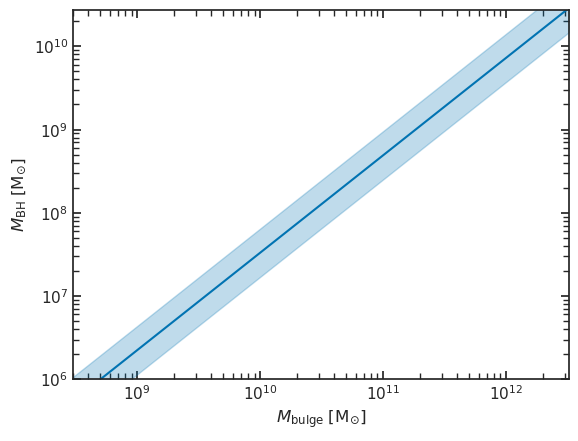

In [6]:
from oddagn.scaling_relations import log_mbh_log_mbulge_scaling

# plot the Mbh-Mbulge scaling from Kormendy & Ho (2013)
fig, ax = plt.subplots()

alpha_kh13 = 1.17
beta_kh13 = 8.69
delta_kh13 = .29

mbulge_plot = np.geomspace(3e8, 3.25e12)
log10_mbulge_plot = np.log10(mbulge_plot)
log10_mbh_exp = log_mbh_log_mbulge_scaling(log10_mbulge_plot, alpha=alpha_kh13, beta=beta_kh13)
log10_mbh_exp_low = log10_mbh_exp - delta_kh13
log10_mbh_exp_high = log10_mbh_exp + delta_kh13
mbh_exp = np.power(10, log10_mbh_exp)
mbh_exp_low = np.power(10, log10_mbh_exp_low)
mbh_exp_high = np.power(10, log10_mbh_exp_high)

ax.plot(mbulge_plot, mbh_exp, color=cs[0])
ax.fill_between(
    mbulge_plot, 
    mbh_exp_low, 
    mbh_exp_high, 
    color=cs[0],
    alpha=.25
)

ax.set_xlabel(r"$M_{\mathrm{bulge}} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_xlim(mbulge_plot.min(), mbulge_plot.max())

ax.set_ylabel(r"$M_{\mathrm{BH}} \; [\mathrm{M}_{\odot}]$")
ax.set_yscale("log")
ax.set_ylim(1e6, 2.75e10)

plt.show()

Of course, we would like to predict $M_{\mathrm{bulge}} \vert M_{\mathrm{BH}}$. Inverting the above relation we have
$$
\begin{align}
\log_{10} \left(M_{\mathrm{bulge}} / 10^{11} \; \mathrm{M}_{\odot}\right) &= \frac{1}{\alpha_{\mathrm{BH}}} \left(\log_{10} M_{\mathrm{BH}} - \beta_{\mathrm{BH}} \pm \Delta_{\mathrm{BH}}\right) \\ 
\Rightarrow \log_{10} M_{\mathrm{bulge}} &= \frac{1}{\alpha_{\mathrm{BH}}} \log_{10} \left(M_{\mathrm{BH}} / 10^{\beta_{\mathrm{BH}}} \; \mathrm{M}_{\odot}\right) + 11 \pm \frac{\Delta_{\mathrm{BH}}}{\alpha_{\mathrm{BH}}} \, .
\end{align}
$$

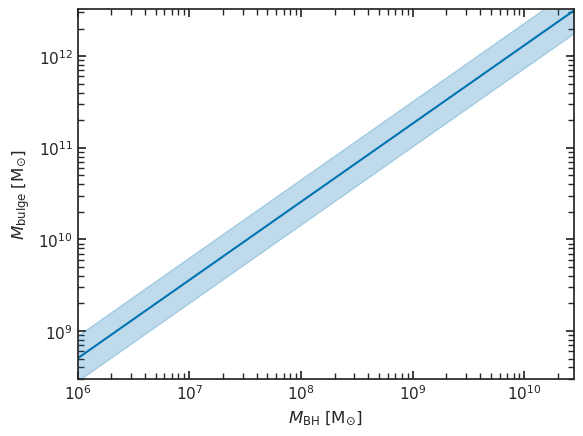

In [7]:
from oddagn.scaling_relations import log_mbulge_log_mbh_scaling

# plot the Mbh-Mbulge scaling from Kormendy & Ho (2013)
fig, ax = plt.subplots()

log10_mbulge_exp = log_mbulge_log_mbh_scaling(log10_mbh_exp, alpha=alpha_kh13, beta=beta_kh13)
log10_mbulge_exp_low = log10_mbulge_exp - delta_kh13 / alpha_kh13
log10_mbulge_exp_high= log10_mbulge_exp + delta_kh13 / alpha_kh13
mbulge_exp = np.power(10, log10_mbulge_exp)
mbulge_exp_low = np.power(10, log10_mbulge_exp_low)
mbulge_exp_high = np.power(10, log10_mbulge_exp_high)

ax.plot(mbh_exp, mbulge_exp, color=cs[0])
ax.fill_between(
    mbh_exp, 
    mbulge_exp_low, 
    mbulge_exp_high, 
    color=cs[0],
    alpha=.25
)

ax.set_ylabel(r"$M_{\mathrm{bulge}} \; [\mathrm{M}_{\odot}]$")
ax.set_yscale("log")
ax.set_ylim(mbulge_plot.min(), mbulge_plot.max())

ax.set_xlabel(r"$M_{\mathrm{BH}} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_xlim(1e6, 2.75e10)

plt.show()

We can also verify that this matches what we get if we invert the relation numerically.

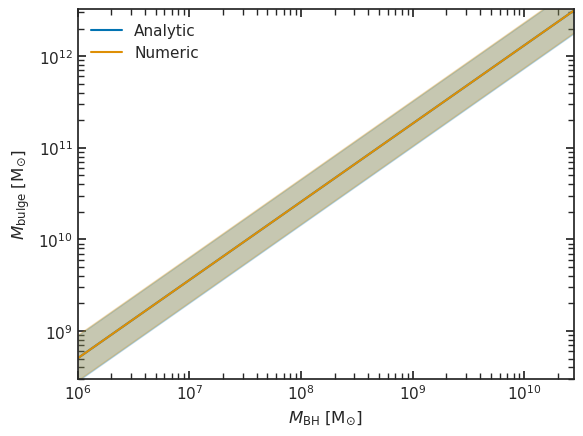

In [8]:
fig, ax = plt.subplots()

ax.plot(mbh_exp, mbulge_exp, color=cs[0], label="Analytic")
ax.fill_between(
    mbh_exp, 
    mbulge_exp_low, 
    mbulge_exp_high, 
    color=cs[0],
    alpha=.25
)

ax.plot(mbh_exp, mbulge_plot, color=cs[1], label="Numeric")
ax.fill_betweenx(
    mbulge_plot, 
    mbh_exp_low, 
    mbh_exp_high, 
    color=cs[1],
    alpha=.25
)

ax.set_ylabel(r"$M_{\mathrm{bulge}} \; [\mathrm{M}_{\odot}]$")
ax.set_yscale("log")
ax.set_ylim(mbulge_plot.min(), mbulge_plot.max())

ax.set_xlabel(r"$M_{\mathrm{BH}} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_xlim(1e6, 2.75e10)

plt.legend()
plt.show()

For the $M_{\mathrm{bulge}} - M_{*}$ scaling we assume the relation from Sesana et al. (2016):

$$
\begin{align}
\frac{M_{\mathrm{bulge}}}{M_{*}} = \begin{cases}
0.6 + 0.018 \left( \log_{10} M_{\mathrm{bulge}} - 9.5 \right) & 9.5 \leq \log_{10} M_{\mathrm{bulge}} < 10.6 \\
0.62 + 0.175 \left( \log_{10} M_{\mathrm{bulge}} - 10.6 \right) & 10.6 \leq \log_{10} M_{\mathrm{bulge}} < 11.4 \\
0.76 + 0.004 \left( \log_{10} M_{\mathrm{bulge}} - 11.4 \right) & 11.4 \leq \log_{10} M_{\mathrm{bulge}}
\end{cases}
\end{align}
$$

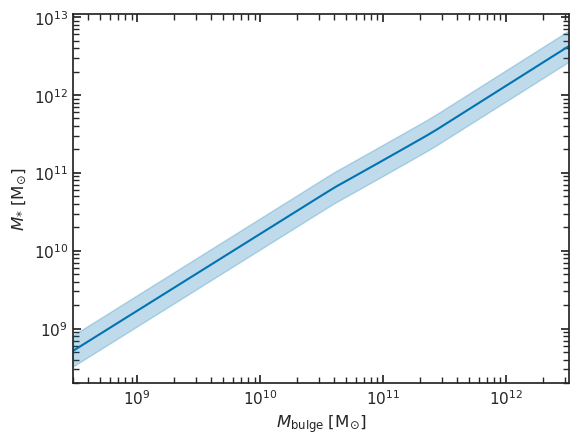

In [9]:
from oddagn.scaling_relations import log_mstellar_log_mbulge_scaling

# plot the Mbh-Mbulge scaling from Kormendy & Ho (2013)
fig, ax = plt.subplots()

delta_s16 = .2

log10_mstellar_exp = log_mstellar_log_mbulge_scaling(log10_mbulge_plot)
log10_mstellar_exp_low = log10_mstellar_exp - delta_s16
log10_mstellar_exp_high = log10_mstellar_exp + delta_s16
mstellar_exp = np.power(10, log10_mstellar_exp)
mstellar_exp_low = np.power(10, log10_mstellar_exp_low)
mstellar_exp_high = np.power(10, log10_mstellar_exp_high)

ax.plot(mbulge_plot, mstellar_exp, color=cs[0])
ax.fill_between(
    mbulge_plot, 
    mstellar_exp_low, 
    mstellar_exp_high, 
    color=cs[0],
    alpha=.25
)

ax.set_xlabel(r"$M_{\mathrm{bulge}} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_xlim(mbulge_plot.min(), mbulge_plot.max())

ax.set_ylabel(r"$M_{*} \; [\mathrm{M}_{\odot}]$")
ax.set_yscale("log")
# ax.set_ylim(1e6, 2.75e10)

plt.show()

We plot the Coulomb logarithm as a function of SMBH total mass below and mass ratio below.

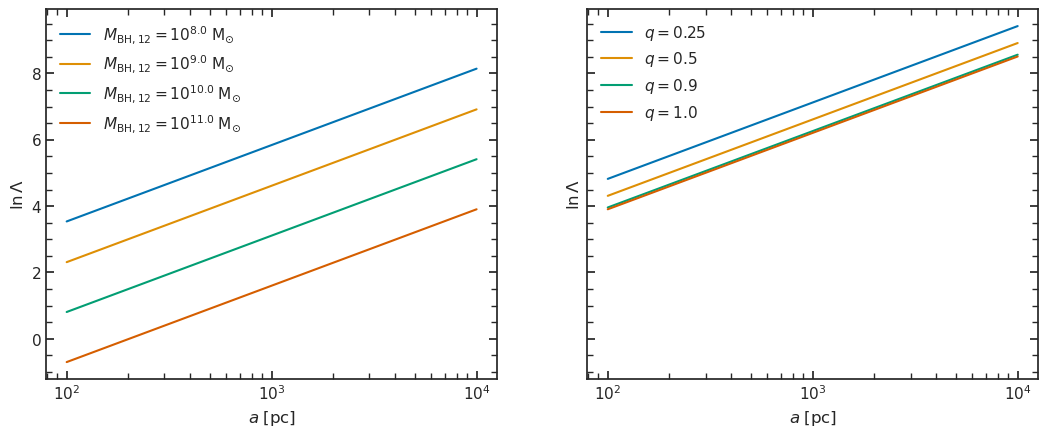

In [10]:
# plot the Coulomb logarithm for different SMBH masses and mass ratios
fig, ax = plt.subplots(ncols=2, figsize=[2*FW, FH], sharey=True)

for i, m12 in enumerate(mbh12):
    mbh = m12 / 2
    log10_mbh = np.log10(mbh)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    galaxy_radius = effective_radius(mstellar)
    coulog = coulomb_logarithm(a_dyn_fric_plot, mbh, mstellar, galaxy_radius)

    ax[0].plot(a_dyn_fric_plot, coulog, label=f"$M_{{\mathrm{{BH}}, 12}} = 10^{{{np.log10(m12)}}} \; \mathrm{{M}}_{{\odot}}$")

ax[0].set_xlabel(r"$a \; [\mathrm{pc}]$")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"$\ln \Lambda$")

for i, q in enumerate(mratq):
    mbh = 1e9 * q / (1 + q)
    log10_mbh = np.log10(mbh)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    galaxy_radius = effective_radius(mstellar)
    coulog = coulomb_logarithm(a_dyn_fric_plot, mbh, mstellar, galaxy_radius)

    ax[1].plot(a_dyn_fric_plot, coulog, label=f"$q = {q}$")

ax[1].set_xlabel(r"$a \; [\mathrm{pc}]$")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"$\ln \Lambda$")

ax[0].legend()
ax[1].legend()
plt.show()

### Velocity Dispersion

We will assume a virialized velocity dispersion for the galaxy, such that $\sigma_{*}^{2}(a) = M_{*}(a) / a$. This also means we must assume a mass profile. We assume a Dehnen galaxy mass profile, such that
$$
M_{*}(r) = M_{*} \left(\frac{r}{r + r_{0}}\right)^{3 - \gamma} \, , \gamma = 1 \, ,
$$
where the scale radius, $r_{0}$, is related to $R_{*}$ by
$$
r_{0} \approx \frac{R_{*} (2^{1 / (3 - \gamma)} - 1)}{0.7549 - 0.00439 \gamma + 0.00322 \gamma^{2} - 0.00182 \gamma^{3}}
$$

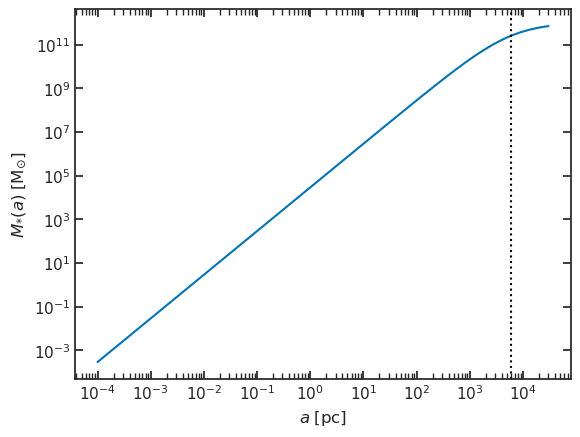

In [11]:
from oddagn.galaxy_properties import mass_enclosed, scale_radius

# plot the Coulomb logarithm
fig, ax = plt.subplots()

mstellar_test = 1e12

menc = mass_enclosed(a_sep, mstellar_test, gamma=1)
r0_test = scale_radius(mstellar_test)

ax.plot(a_sep, menc)
ax.axvline(r0_test, color='k', linestyle=":")

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$M_{*}(a) \; [\mathrm{M}_{\odot}]$")
ax.set_yscale("log")

plt.show()

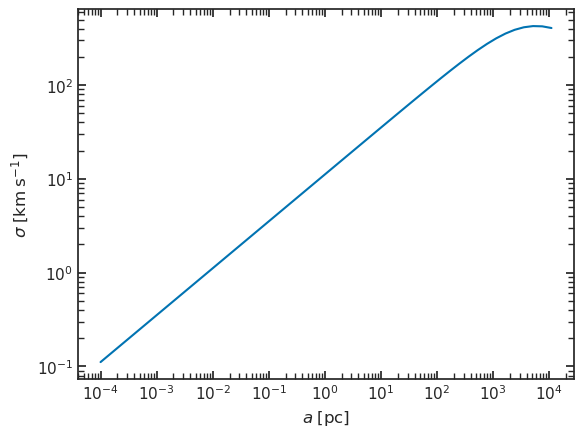

In [12]:
from oddagn.galaxy_properties import velocity_dispersion

# plot velocity dispersion as a function of radius
fig, ax = plt.subplots()

vel_disp = velocity_dispersion(np.geomspace(1e-4, effective_radius(1e12)), 1e12, gamma=1)

ax.plot(np.geomspace(1e-4, effective_radius(1e12)), vel_disp)

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$\sigma \; [\mathrm{km} \; \mathrm{s}^{-1}]$")
ax.set_yscale("log")

plt.show()

The evolution to dynamical friction is therefore plotted as
$$
\begin{equation}
    \frac{da}{dt} = -0.428 \ln \Lambda \frac{M_{\mathrm{BH}, 2}}{a v_{c}} = -0.302 \ln \Lambda \frac{M_{\mathrm{BH}, 2}}{a \sigma} \, .
\end{equation}
$$

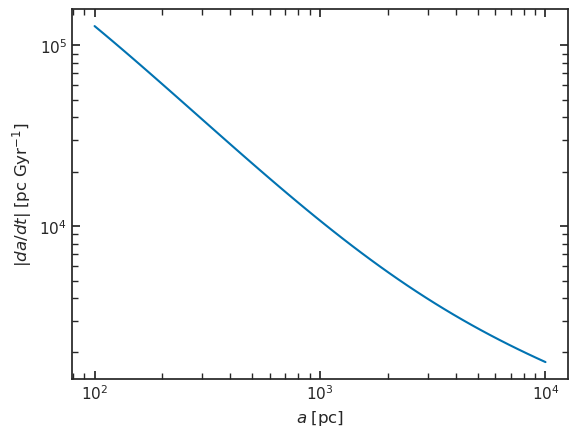

In [13]:
from oddagn.evolution_rates import da_dt_dyn

# plot rate of SMBH separation change
fig, ax = plt.subplots()

mbh_test = 1e9
log10_mbh_test = np.log10(mbh_test)
log10_mbulge_test = log_mbulge_log_mbh_scaling(log10_mbh_test, alpha=alpha_kh13, beta=beta_kh13)
log10_mstellar_test = log_mstellar_log_mbulge_scaling(log10_mbulge_test)
mstellar_test = np.power(10, log10_mstellar_test)

da_dt = da_dt_dyn(a_dyn_fric_plot, mstellar_test, mbh_test, 1)

ax.plot(a_dyn_fric_plot, np.abs(da_dt))

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")
ax.set_yscale("log")

plt.show()

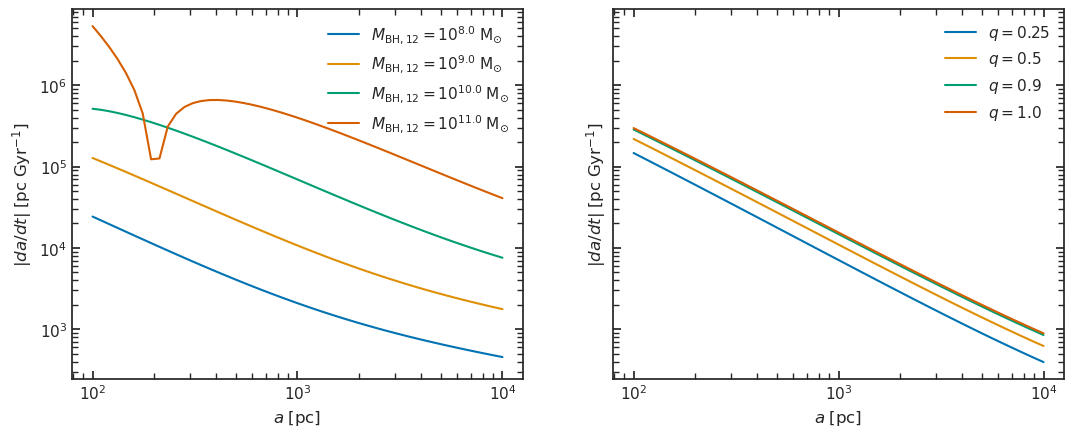

In [14]:
# plot the separation evolution rate for different SMBH masses and mass ratios
fig, ax = plt.subplots(ncols=2, figsize=[2*FW, FH], sharey=True)

for i, m12 in enumerate(mbh12):
    log10_mbh = np.log10(m12)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    da_dt = da_dt_dyn(a_dyn_fric_plot, mstellar, m12, 1)

    ax[0].plot(a_dyn_fric_plot, np.abs(da_dt), label=f"$M_{{\mathrm{{BH}}, 12}} = 10^{{{np.log10(m12)}}} \; \mathrm{{M}}_{{\odot}}$")

ax[0].set_xlabel(r"$a \; [\mathrm{pc}]$")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")

for i, q in enumerate(mratq):
    mbh = 1e9
    log10_mbh = np.log10(mbh)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    da_dt = da_dt_dyn(a_dyn_fric_plot, mstellar, mbh, q)

    ax[1].plot(a_dyn_fric_plot, np.abs(da_dt), label=f"$q = {q}$")

ax[1].set_xlabel(r"$a \; [\mathrm{pc}]$")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")
ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
plt.show()

## Stellar Hardening

Dynamical friction eventually brings the secondary SMBH to within the gravitational influence radius of the primary SMBH, $r_{\mathrm{inf}, 1} = M_{\mathrm{BH}, 1} / \sigma^{2}$.
At this point the SMBHs gravitationally bind, forming a SMBHB \citep[e.g.][]{merritt_dynamics_2013}.
The SMBHB initially exists as a "soft" binary, which is defined as a binary which has a relative orbital velocity, $v_{\mathrm{o}}$, less than the typical velocity of nearby stars, $\sigma$, \citep{merritt_dynamics_2013}.
While dynamical friction still drives the SMBHB's evolution when the binary semi-major axis $a \approx r_{\mathrm{inf}, 1}$, three-body interactions between the SMBHB and individual nearby stars also start to remove energy from the system.

As the binary orbit continues to shrink, these three-body interactions come to dominate the SMBHB's evolution.
When the binary orbit shrinks to the point that its orbital velocity is larger than the velocity dispersion of nearby stars, $v_{\mathrm{o}} > \sigma$, we consider the binary to be "hard" \citep{binney_galactic_2008,merritt_dynamics_2013}.
At this point, the binary evolution is entirely dominated by three-body interactions in a process called "stallar hardening".
% Conversely, a SMBHB can be described as "hard" when $v_{\mathrm{o}} > \sigma$ \citep{binney_galactic_2008,merritt_dynamics_2013}.
For a binary on a circular orbit we have $v_{\mathrm{o}} = \sqrt{M_{\mathrm{BH}, 12} / a}$, where $M_{\mathrm{BH}, 12} = M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}$.
The binary is therefore hardened when
\begin{align}
    a_{h} &< \frac{M_{\mathrm{BH}, 12}}{\sigma^{2}(a_{h})} \\
    \Rightarrow a_{h} &< \frac{a_{h} M_{\mathrm{BH}, 12}}{M_{*}(a_{h})} \\
    1 &< \frac{M_{\mathrm{BH}, 12}}{M_{*} \left(\frac{a_{h}}{a_{h} + r_{0}}\right)^{3 - \gamma}} \\
    \frac{a_{h}}{a_{h} + r_{0}} &< \left(\frac{M_{\mathrm{BH}, 12}}{M_{*}}\right)^{1 / (3 - \gamma)} \\ 
    a_{h} &< \frac{r_{0}}{\left(\frac{M_{*}}{M_{\mathrm{BH}, 12}}\right)^{1 / (3 - \gamma)} - 1} \\
\end{align}
where $a_{h}$ is the semi-major axis of the hardened binary, which for circular binaries is equivalent to the binary separation.

In [15]:
def hard_binary_radius(mbh, mstellar, gamma=1):
    r0 = scale_radius(mstellar, gamma=gamma)
    scaled_mass = mstellar / mbh

    a_hard = r0 / (np.power(scaled_mass, 1 / (3 - gamma)) - 1)
    return a_hard

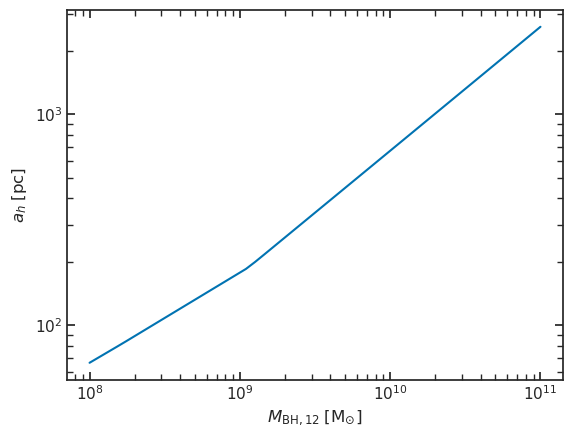

In [16]:
# plot rate of SMBH separation change
fig, ax = plt.subplots()

mbh_test = np.logspace(8, 11)
log10_mbh_test = np.log10(mbh_test)
log10_mbulge_test = log_mbulge_log_mbh_scaling(log10_mbh_test, alpha=alpha_kh13, beta=beta_kh13)
log10_mstellar_test = log_mstellar_log_mbulge_scaling(log10_mbulge_test)
mstellar_test = np.power(10, log10_mstellar_test)

a_hard = hard_binary_radius(mbh_test, mstellar_test, gamma=1)

ax.plot(mbh_test, a_hard)

ax.set_xlabel(r"$M_{\mathrm{BH}, 12} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$a_{h} \; [\mathrm{pc}]$")
ax.set_yscale("log")

plt.show()

Neither dynamical friction nor stellar hardening are well defined 
between $r_{\mathrm{inf}, 1}$ and $a_{h}$, and thus the evolution in this range is poorly modeled.
In the rest of this section we will focus on the evolution of the SMBHB after it is hard, which is driven by three-body interactions with individual nearby stars.
We closely follow the arguments in \citet{hills_effect_1983}, \citet{quinlan_dynamical_1996}, and \citet{merritt_dynamics_2013}.

Consider a star of mass $m \ll M_{\mathrm{BH}, 12}$, which approaches a hardened SMBHB from infinity with velocity $\vec{v}_{\infty}$ on an unbound orbit.
The SMBHB has energy
\begin{equation}
    E_{\mathrm{BHB}} = - \frac{M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2}}{2 a} \, .
\end{equation}
The closest approach of the star can be approximated as
\begin{equation}
    r_{\min} \approx \frac{b^{2} v_{f}^{2}}{2 M_{\mathrm{BH}, 12}} \, ,
\end{equation}
where $b$ is the impact parameter, and where we assume that $v_{f} \ll M_{\mathrm{BH}, 12} / b$, which is reasonable for close encounters \citep{merritt_dynamics_2013}.

The largest change in energy comes from stars where $r_{\min} \approx a$.
Furthermore, most of the change in energy comes from interacting with the secondary SMBH, which is further from the barycenter of the SMBHB.
Thus the star feels an acceleration $\dot{v} \approx M_{\mathrm{BH}, 2} / a^{2}$, which acts for time $\Delta t \approx \sqrt{a^{3} / M_{\mathrm{BH}, 12}}$.
The star's change in velocity is therefore $\Delta \vec{v} \approx (M_{\mathrm{BH}, 2} / M_{\mathrm{BH}, 12}) v_{\mathrm{o}}$.
The total change in energy of the star can be approximated as
\begin{align}
    \Delta E_{*} &\approx \frac{1}{2} m \left[(\vec{v}_{\infty} + \Delta \vec{v}) - \vec{v}_{\infty}\right] \nonumber \\
    & \approx \frac{m M_{\mathrm{BH}, 2}}{M_{\mathrm{BH}, 12}} v_{\mathrm{o}}^{2} \, .
\end{align}
The energy gained by the star is extracted from the SMBHB, $\Delta E_{\mathrm{BHB}} = - \Delta E_{*}$.
Thus, by combining \cref{eq:orb_energy,eq:energy_change} we can express the fractional energy change of the SMBHB as \citep{merritt_dynamics_2013}
\begin{equation}
    \frac{\Delta E_{\mathrm{BHB}}}{E_{\mathrm{BHB}}} \approx -2 \frac{m}{M_{\mathrm{BH}, 1}} v_{\mathrm{o}} \, .
\end{equation}

The approximation in \cref{eq:frac_e_change_bhb} motivates the definition of the dimensionless energy change parameter \citep{hills_effect_1983,quinlan_dynamical_1996,merritt_dynamics_2013}
\begin{equation}
    C \equiv \frac{M_{\mathrm{BH}, 12}}{2 m} \frac{\Delta E_{\mathrm{BHB}}}{E_{\mathrm{BHB}}} \, .
\end{equation}
$C$ must generally be computed numerically via scattering experiments, as its value depends on the initial conditions of the system, including the initial phase and orientation of the SMBHB.
For a specific $v_{f}$, the rate of change in binary energy is
\begin{equation}
    \left. \frac{d{E_{\mathrm{BHB}}}}{d{t}} \right|_{v_{f}} = - \frac{4 \pi M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2} \rho_{\mathrm{inf}}}{v_{f}} \int_{0}^{\infty} d{x} x \langle C \rangle \, ,
\end{equation}
where $\langle C \rangle$ is the value of $C$ averaged over SMBHB phases and orientations,
\begin{equation}
    x = p / p_{0}, \qquad p_{0} = \sqrt{\frac{2 M_{\mathrm{BH}, 12} a}{v_{f}^{2}}} \, ,
\end{equation} $p_{0}$ corresponds to the approximate impact parameter of a star with $r_{\min} = a$, and $\rho_{\mathrm{inf}}$ is the stellar mass density computed at the influence radius, $r_{\mathrm{inf}}$, of the SMBHB \citep{sesana_scattering_2015}.
This is usually defined as the radius at which the contained stellar mass is twice the SMBHB mass, $M_{*}(< r_{\mathrm{inf}}) = 2 M_{\mathrm{BH}, 12}$ \citep{merritt_dynamics_2013,sesana_scattering_2015}.

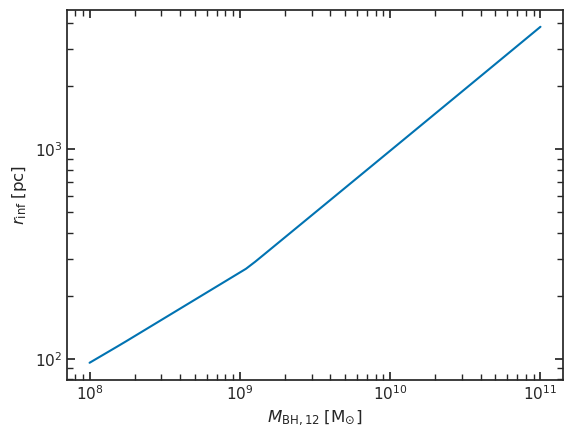

In [17]:
from oddagn.evolution_rates import influence_radius

# plot rate of SMBH separation change
fig, ax = plt.subplots()

mbh_test = np.logspace(8, 11)
log10_mbh_test = np.log10(mbh_test)
log10_mbulge_test = log_mbulge_log_mbh_scaling(log10_mbh_test, alpha=alpha_kh13, beta=beta_kh13)
log10_mstellar_test = log_mstellar_log_mbulge_scaling(log10_mbulge_test)
mstellar_test = np.power(10, log10_mstellar_test)

r_inf = influence_radius(mbh_test, mstellar_test, gamma=1)

ax.plot(mbh_test, r_inf)

ax.set_xlabel(r"$M_{\mathrm{BH}, 12} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$r_{\mathrm{inf}} \; [\mathrm{pc}]$")
ax.set_yscale("log")

plt.show()

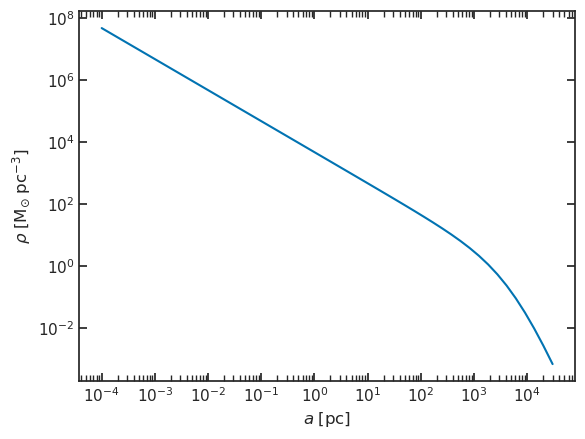

In [18]:
from oddagn.galaxy_properties import stellar_mass_density

# plot rate of SMBH separation change
fig, ax = plt.subplots()

rho_test = stellar_mass_density(a_sep, 1e12, gamma=1)

ax.plot(a_sep, rho_test)

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$\rho \; [\mathrm{M}_{\odot} \; \mathrm{pc}^{-3}]$")
ax.set_yscale("log")

plt.show()

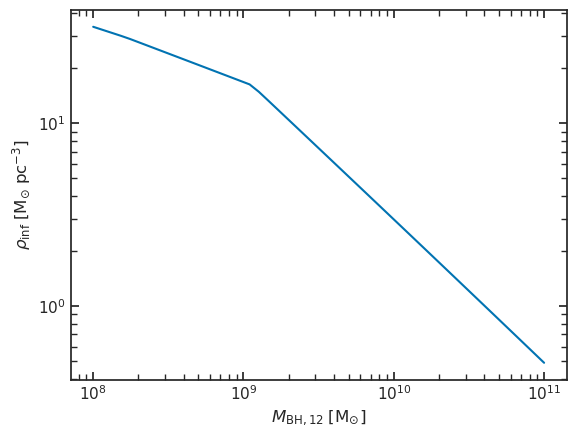

In [19]:
# plot rate of SMBH separation change
fig, ax = plt.subplots()

rho_inf = stellar_mass_density(r_inf, mstellar_test, gamma=1)

ax.plot(mbh_test, rho_inf)

ax.set_xlabel(r"$M_{\mathrm{BH}, 12} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$\rho_{\mathrm{inf}} \; [\mathrm{M}_{\odot} \; \mathrm{pc}^{-3}]$")
ax.set_yscale("log")

plt.show()

Using \cref{eq:orb_energy}, we can express \cref{eq:dE_dt_hard_v} in terms of $a$ as
\begin{equation}
    \left. \frac{d{}}{d{t}} \left(\frac{1}{a}\right) \right|_{v_{f}} = \frac{\rho_{\mathrm{inf}}}{v_{f}} H_{1}(v_{f}), \qquad H_{1}(v_{f}) = 8 \pi \int_{0}^{\infty} d{x} x \langle C \rangle \, .
\end{equation}
Finally, we integrate over the velocity distribution function, $\psi(v_{f})$, to obtain the the binary hardening rate, $H$.
For a Maxwellian $\psi(v_{f})$, \cref{eq:maxwell}, $H$ is \citep{quinlan_dynamical_1996,merritt_dynamics_2013,sesana_scattering_2015}

\begin{align}
    H &\equiv \frac{\sigma_{\mathrm{inf}}}{\rho_{\mathrm{inf}}} \frac{d{}}{d{t}} \left(\frac{1}{a}\right) & \Rightarrow \left.\frac{da}{dt}\right|_{\mathrm{sh}} &= - \frac{H \rho_{\mathrm{inf}}}{\sigma_{\mathrm{inf}}} a^{2} \, ,
\end{align}

where $\sigma_{\mathrm{inf}}$ is the stellar velocity dispersion at $r_{\mathrm{inf}}$ \citep{sesana_scattering_2015}.
Importantly, \cref{eq:da_dt_hard} suggests that hard SMBHBs harden at a constant rate.
This has been verified by scattering experiments, which also find that $H \approx 15$ \citep{quinlan_dynamical_1996,sesana_scattering_2015}.

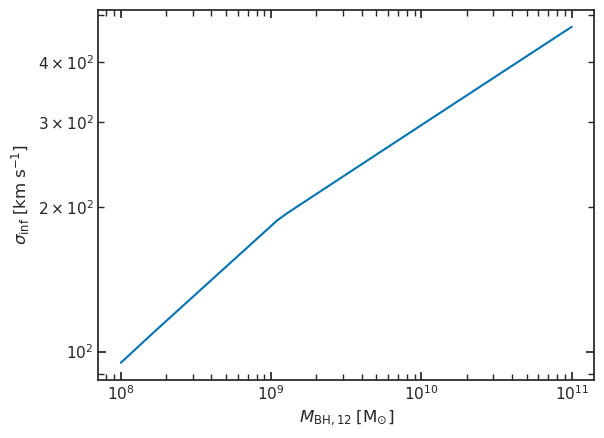

In [20]:
# plot rate of SMBH separation change
fig, ax = plt.subplots()

sigma_inf = velocity_dispersion(r_inf, mstellar_test, gamma=1)

ax.plot(mbh_test, sigma_inf)

ax.set_xlabel(r"$M_{\mathrm{BH}, 12} \; [\mathrm{M}_{\odot}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$\sigma_{\mathrm{inf}} \; [\mathrm{km} \; \mathrm{s}^{-1}]$")
ax.set_yscale("log")

plt.show()

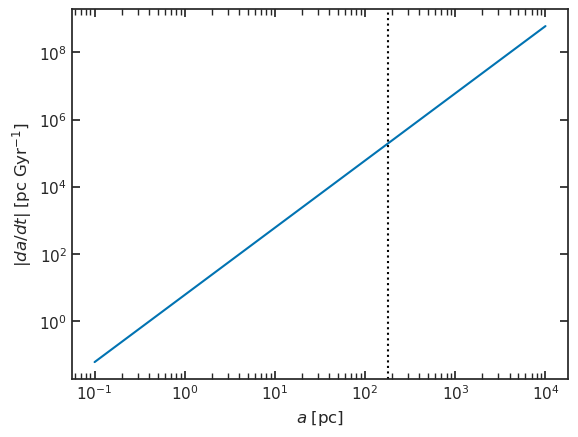

In [21]:
from oddagn.evolution_rates import da_dt_sh

# plot rate of SMBH separation change
fig, ax = plt.subplots()

a_sh_plot = np.geomspace(1e-1, 1e4)

mbh_test = 1e9
log10_mbh_test = np.log10(mbh_test)
log10_mbulge_test = log_mbulge_log_mbh_scaling(log10_mbh_test, alpha=alpha_kh13, beta=beta_kh13)
log10_mstellar_test = log_mstellar_log_mbulge_scaling(log10_mbulge_test)
mstellar_test = np.power(10, log10_mstellar_test)

da_dt = da_dt_sh(a_sh_plot, mstellar_test, mbh_test)
ax.plot(a_sh_plot, np.abs(da_dt))

a_hard = hard_binary_radius(mbh_test, mstellar_test, gamma=1)
ax.axvline(a_hard, color="k", linestyle=":")

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")
ax.set_yscale("log")

plt.show()

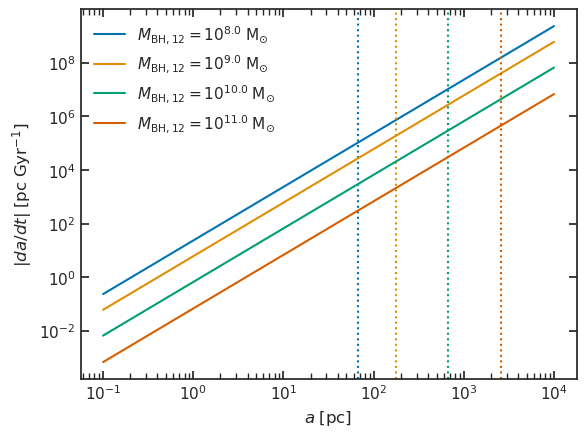

In [22]:
# plot the separation evolution rate for different SMBH masses and mass ratios
fig, ax = plt.subplots(ncols=1, figsize=[FW, FH], sharey=True)

for i, m12 in enumerate(mbh12):
    log10_mbh = np.log10(m12)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    da_dt = da_dt_sh(a_sh_plot, mstellar, m12)

    ax.plot(a_sh_plot, np.abs(da_dt), color=cs[i],
            label=f"$M_{{\mathrm{{BH}}, 12}} = 10^{{{np.log10(m12)}}} \; \mathrm{{M}}_{{\odot}}$")

    a_hard = hard_binary_radius(m12, mstellar, gamma=1)
    ax.axvline(a_hard, color=cs[i], linestyle=":")

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")
ax.set_yscale("log")

ax.legend()
plt.show()

## Gravitational Waves

As the SMBHB hardens, and its orbit shrinks even further, its evolution is eventually dominated by GW emission.
In this section we therefore derive relations governing the evolution of a SMBHB due to GW emission.
We closely follow the derivations in \citet{schutz_gravitational_1999}, \citet{phinney_practical_2001}, \citet{flanagan_basics_2005}, \citet{mingarelli_gravitational_2016}, and \citet{misner_gravitation_2017}.

From \cref{eq:dEdt_general}, we know that $\dot{E} = (1 / 5) \langle \dddot{\mathcal{I}}_{i j} \dddot{\mathcal{I}}_{i j} \rangle$.
To calculate the energy loss of the binary due to GWs we thus need to calculate the components of the reduced quadrupole moment, $\mathcal{I}_{i j}$, \cref{eq:reduced_quad_mom}.

To simplify the calculation, we confine the orbit of the binary to the $x - y$ plane.
We adopt barycentric coordinates such that
\begin{equation}
\begin{split}
    \vec{x}_{1} &= \frac{a M_{\mathrm{BH}, 2}}{M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}} \begin{pmatrix} \cos \theta, & \sin \theta, & 0\end{pmatrix} \\ 
    \vec{x}_{2} &= \frac{a M_{\mathrm{BH}, 1}}{M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}} \begin{pmatrix} -\cos \theta, & -\sin \theta, & 0 \end{pmatrix} \, ,
\end{split}
\end{equation}
where $\vec{x}_{1}$ is the position of the primary SMBH with mass $M_{\mathrm{BH}, 1}$, $\vec{x}_{2}$ is the position of the secondary with mass $M_{\mathrm{BH}, 2}$, $a = x_{1} + x_{2}$, and $\theta$ is the polar angle, which can be expressed in terms of the orbital frequency, $f_{\mathrm{o}}$ and orbital angular frequency, $\omega_{\mathrm{o}}$, as $\theta = 2 \pi f_{\mathrm{o}} t = \omega_{\mathrm{o}} t$.
Using \cref{eq:barycentric_coords} in \cref{eq:quad}, we can calculate the components of $I_{i j}$.
For example,
\begin{align}
    I_{x x} &= \int d^{3}x \rho x_{x} x_{x} \nonumber \\
    &= \frac{a^{2} M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2}^{2}}{\left(M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}\right)^{2}} \cos^{2} \omega_{\mathrm{o}} t + \frac{a^{2} M_{\mathrm{BH}, 1}^{2} M_{\mathrm{BH}, 2}}{\left(M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}\right)} \cos^{2} \omega_{\mathrm{o}} t \nonumber \\
    &= \frac{a^{2} M_{\mathrm{BH}, 1}^{2} M_{\mathrm{BH}, 2}^{2}}{\left(M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}\right)^{2}} \left(\frac{1}{M_{\mathrm{BH}, 1}} + \frac{1}{M_{\mathrm{BH}, 2}}\right) \cos^{2} \omega_{\mathrm{o}} t \nonumber \\
    &= \frac{a^{2} M_{\mathrm{BH}, 1}^{2} M_{\mathrm{BH}, 2}^{2}}{\left(M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}\right)^{2}} \left(\frac{M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}}{M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2}}\right) \cos^{2} \omega_{\mathrm{o}} t \nonumber \\
    &= \frac{a^{2} M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2}}{M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2}} \cos^{2} \omega_{\mathrm{o}} t \nonumber \\
    &= \mu a^{2} \cos^{2} \omega_{\mathrm{o}} t \nonumber \\
    &= \frac{1}{2} \mu a^{2} \left[1 + \cos(2 \omega_{\mathrm{o}} t)\right] \, ,
    % &= \frac{1}{2} \mu a^{2} \left[1 + \cos(\omega_{\mathrm{GW}} t)\right]
\end{align}
where $\mu = M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2} / (M_{\mathrm{BH}, 1} + M_{\mathrm{BH}, 2})$ is the reduced mass of the binary.

Similarly,
\begin{equation}
    I_{y y} = \frac{1}{2} \mu a^{2} \left[1 - \cos(2 \omega_{\mathrm{o}} t)\right] \, ,
\end{equation}
and
\begin{equation}
    I_{x y} = I_{y x} = \frac{1}{2} \mu a^{2} \sin(2 \omega_{\mathrm{o}} t) \, .
\end{equation}
We can also see by inspecting \cref{eq:barycentric_coords} that all $I_{i j}$ involving $z$ are zero by the definition of our coordinate system.
Combining \cref{eq:I_xx,eq:I_yy,eq:I_xy}, we therefore have
\begin{equation}
    I_{i j} = \frac{1}{2} \mu a^{2} \begin{bmatrix}
    1 + \cos(2 \omega_{\mathrm{o}} t) & \sin(2\omega_{\mathrm{o}} t) & 0 \\
    \sin(2 \omega_{\mathrm{o}} t) & 1 - \cos(2 \omega_{\mathrm{o}} t) & 0 \\
    0 & 0 & 0
    \end{bmatrix}
\end{equation}
By inspection of \cref{eq:I_ij}, we can see the trace is $I = \mu a^{2}$.
Substituting this in \cref{eq:reduced_quad_mom}, we find
\begin{align}
    \mathcal{I}_{i j} & = I_{i j} - \frac{1}{3} \delta_{ij} \mathrm{trace}(I) \nonumber \\
    & = \frac{1}{2} \mu a^{2} \begin{bmatrix}
    1/3 + \cos(2 \omega_{\mathrm{o}} t) & \sin(2 \omega_{\mathrm{o}} t) & 0 \\
    \sin(2 \omega_{\mathrm{o}} t) & 1/3 - \cos(2 \omega_{\mathrm{o}} t) & 0 \\
    0 & 0 & -2/3
    \end{bmatrix}
\end{align}

We can now compute the energy the binary loses to gravitational radiation per unit time, and by extension the evolution of the binary separation and $f_{\mathrm{GW}}$.
We first compute $\dddot{\mathcal{I}}_{i j}$. From \cref{eq:reduced_quad_mom_binary},
\begin{align}
    \dddot{\mathcal{I}}_{i j} & = - 4 \mu a^{2} \omega_{\mathrm{o}}^{3} \begin{bmatrix}
    - \sin(2 \omega_{\mathrm{o}} t) & \cos(2 \omega_{\mathrm{o}} t) & 0 \\
    \cos(2 \omega_{\mathrm{o}} t) & \sin(2 \omega_{\mathrm{o}} t) & 0 \\
    0 & 0 & 0
    \end{bmatrix}
\end{align}
The differential energy lost to gravitational radiation per unit time is therefore
\begin{align}
    \frac{dE}{dt} &= - \frac{1}{5} \langle \dddot{\mathcal{I}}_{i j} \dddot{\mathcal{I}}^{i j} \rangle \nonumber \\
    &= - \frac{16}{5} \mu^{2} a^{4} \omega_{\mathrm{o}}^{6} \langle 2 \sin^{2}(2 \omega_{\mathrm{o}} t) + 2 \cos^{2}( 2 \omega_{\mathrm{o}} t)\rangle \nonumber \\
    &= - \frac{32}{5} \mu^{2} a^{4} \omega_{\mathrm{o}}^{6} \, .
\end{align}
Using Kepler's third law, we can re-write this in terms of $\mu$, $a$, and binary total mass, $M_{\mathrm{BH}, 12}$:
\begin{equation}
    \frac{dE}{dt} = -\frac{32}{5} \frac{\mu^{2} M_{\mathrm{BH}, 12}^{3}}{a^{5}} \, .
\end{equation}

The GW energy radiated by the binary is supplied by its orbital energy, \cref{eq:orb_energy}, which can be expressed in terms of $\mu$ as
\begin{equation}
    E = - \frac{1}{2} \frac{M_{\mathrm{BH}, 1} M_{\mathrm{BH}, 2}}{a} = - \frac{1}{2} \frac{\mu M_{\mathrm{BH}, 12}}{a} \, .
\end{equation}
Taking the time derivative of \cref{eq:orb_energy_reduced}, we find that the binary separation evolves as
\begin{equation}
    % a = - \frac{1}{2} \mu M_{\mathrm{BH}, 12} E^{-1}
    % \dot{a} = \frac{1}{2} \mu M_{\mathrm{BH}, 12} E^{-2} \dot{E}
    \dot{a} = - \frac{64}{5} \frac{\mu M_{\mathrm{BH}, 12}^{2}}{a^{3}}
\end{equation}
The GW frequency, $f_{\mathrm{GW}}$, is twice the orbital frequency, $f_{\mathrm{GW}} = 2 f_{\mathrm{o}} = \omega_{\mathrm{o}} / \pi$.
This, in turn, is related to the binary separation by Kepler's Third Law, $\omega_{\mathrm{o}}^{2} = M_{\mathrm{BH}, 12} a^{-3}$.
Energy lost to gravitational radiation therefore also drives evolution of $f_{\mathrm{GW}}$.
We can derive this starting from Kepler's Third Law:
\begin{equation}
    \left(\pi f_{\mathrm{GW}}\right)^{2} = \frac{M_{\mathrm{BH}, 12}}{a^{3}}
\end{equation}
Taking the time derivative of \cref{eq:kepler3} and substituting in \cref{eq:da_dt_gw} we find
\begin{align}
    \Rightarrow f_{\mathrm{GW}} \dot{f}_{\mathrm{GW}} &= - \frac{3 M_{\mathrm{BH}, 12}}{2 \pi^{2}} a^{-4} \dot{a} \nonumber \\
    &= - \frac{3 M_{\mathrm{BH}, 12}}{2 \pi^{2}} a^{-4} \dot{a} \nonumber \\
    & = \frac{96}{5} \frac{\mu M_{\mathrm{BH}, 12}^{3}}{\pi^{2} a^{7}} \, .
\end{align}
Using Kepler's Third Law to eliminate the dependence on $a$, we find
\begin{align}
    \dot{f}_{\mathrm{GW}} &= \frac{96}{5} \pi^{8 / 3} \mu M_{\mathrm{BH}, 12}^{2 / 3} f_{\mathrm{GW}}^{11/3} \nonumber \\
    &= \frac{96}{5} \pi^{8 / 3} \mathcal{M}^{5 / 3} f_{\mathrm{GW}}^{11/3} \, ,
\end{align}
where in the last line we define the binary chirp mass, $\mathcal{M}^{5 / 3} = \mu M_{\mathrm{BH}, 12}^{2 / 3}$.

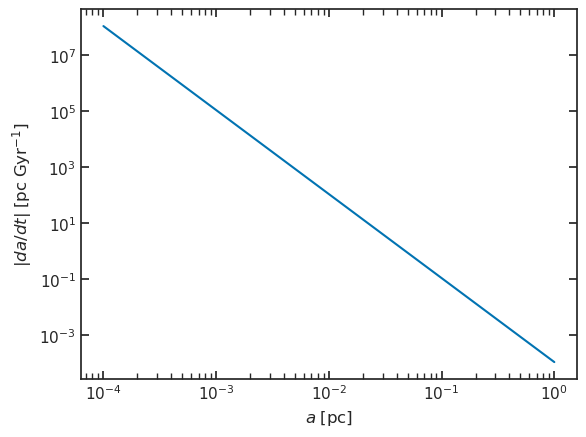

In [23]:
from oddagn.evolution_rates import da_dt_gw

# plot rate of SMBH separation change
fig, ax = plt.subplots()

a_gw_plot = np.geomspace(1e-4, 1e0)

mbh_test = 1e9
q_test = 1

da_dt = da_dt_gw(a_gw_plot, mbh_test, q_test)
ax.plot(a_gw_plot, np.abs(da_dt))

ax.set_xlabel(r"$a \; [\mathrm{pc}]$")
ax.set_xscale("log")
ax.set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")
ax.set_yscale("log")

plt.show()

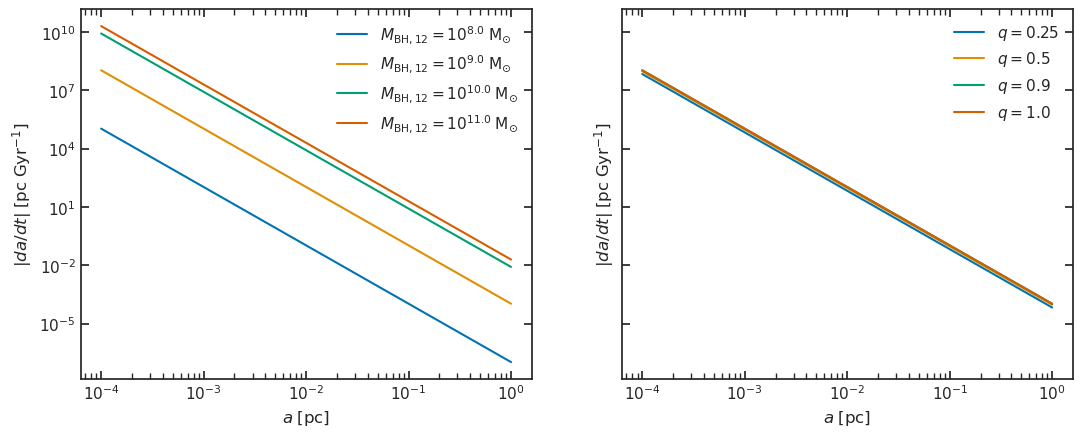

In [24]:
# plot the separation evolution rate for different SMBH masses and mass ratios
fig, ax = plt.subplots(ncols=2, figsize=[2*FW, FH], sharey=True)

for i, m12 in enumerate(mbh12):
    log10_mbh = np.log10(m12)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    da_dt = da_dt_gw(a_gw_plot, m12, q=1)

    ax[0].plot(a_gw_plot, np.abs(da_dt), color=cs[i],
               label=f"$M_{{\mathrm{{BH}}, 12}} = 10^{{{np.log10(m12)}}} \; \mathrm{{M}}_{{\odot}}$")

ax[0].set_xlabel(r"$a \; [\mathrm{pc}]$")
ax[0].set_xscale("log")
ax[0].set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")

for i, q in enumerate(mratq):
    mbh = 1e9
    log10_mbh = np.log10(mbh)
    log10_mbulge = log_mbulge_log_mbh_scaling(np.log10(m12), alpha=alpha_kh13, beta=beta_kh13)
    log10_mstellar = log_mstellar_log_mbulge_scaling(log10_mbulge)
    mstellar = np.power(10, log10_mstellar)
    da_dt = da_dt_gw(a_gw_plot, mbh, q)

    ax[1].plot(a_gw_plot, np.abs(da_dt), color=cs[i], label=f"$q = {q}$")

ax[1].set_xlabel(r"$a \; [\mathrm{pc}]$")
ax[1].set_xscale("log")
ax[1].set_ylabel(r"$|da / dt| \; [\mathrm{pc} \; \mathrm{Gyr}^{-1}]$")
ax[1].set_yscale("log")

ax[0].legend()
ax[1].legend()
plt.show()

# Modeling

# Discussion